In [19]:
import numpy as np
from tensorflow.keras.models import load_model
# 모델 파일 load
model=load_model('best_chatbot3.h5')
import joblib
# tfidf파일 load
tfidf=joblib.load('tfidf_chatbot.pkl')
import re
from konlpy.tag import Okt
t=Okt()

OSError: No file or directory found at best_chatbot3.h5

In [ ]:
import pymongo
conn = pymongo.MongoClient() #몽고db 서버에 연결
answers=conn.baenangE.answers
# tfidf파일 load
tfidf_daily_life=joblib.load('tfidf_chatbot_daily_life.pkl') # 입력받은 문장을 벡터화 하기 위한 파일
daily_life=joblib.load('vetorized_chatbot_daily_life.pkl') # 기존 질문 문장들을 벡터화한 파일, 위에서 입력받은 문장과 유사도를 비교
# new_post 와 contents의 거리 구하는 함수 생성
import scipy as sp

def dist_raw(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())

In [ ]:
import random

def random_list() : # DB에서 여행지 목록 랜덤으로 불러오기
    docs = answers.find({"place_area": "제주도"}, {"_id": 0, "place_idx": 0})  # area가 제주도인것만 그리고 _id, Place_idx 뺴고
    docs_list_info = []
    for doc in docs:
        docs_list = list(doc.values())  # values값만 추출
        docs_list_info.append(docs_list[1])  # 리스트로 변환
    random_list_info = random.sample(docs_list_info, 10)  # 랜덤함수 사용 10개만 추출
    
    return '-'+'\n-'.join(random_list_info)


def like_list() : # 좋아요 높은 순으로 가져오기
    docs = answers.find({}, {"_id": 0, "place_idx": 0}).sort("place_like", pymongo.DESCENDING)  # 내림차순으로 모든정보 가져오기
    docs_list_info = []
    for doc in docs:
        docs_list = doc.get("place_info")  # place_info만 추출
        docs_list_info.append(docs_list)  # list안에 넣기

    return '-'+'\n-'.join(docs_list_info[:5]) # 5개만 추출


def view_list() : # 조회수 높은 순으로 가져오기
    docs = answers.find({}, {"_id": 0, "place_idx": 0}).sort("place_view", pymongo.DESCENDING)  # 내림차순으로 가져오기
    docs_list_info = []
    for doc in docs:
        docs_list = doc.get("place_info")  # place_info만 추출
        docs_list_info.append(docs_list)  # list안에 넣기

    return '-'+'\n-'.join(docs_list_info[:10]) # 10개만 추출

In [20]:
def baenangE_daily_life(str):
    # test text 벡터화
    # 형태소 분석 후 띄어쓰기로 구분하여 하나의 문장으로 만들기
    new_post_tokens = [t.morphs(row) for row in [str]]

    new_post_for_vectorize = []

    for content in new_post_tokens:
        sentence = ''
        for word in content:
            sentence = sentence + ' ' + word

        new_post_for_vectorize.append(sentence)

    new_post_for_vectorize
    new_post_vec = tfidf_daily_life.transform(new_post_for_vectorize)
  
    # 다른 결과를 얻을 수 있음
    best_doc = None
    best_dist = 65535
    best_i = None

    for i in range(0, 11823):
        post_vec = daily_life.getrow(i)

        # 함수호출
        d = dist_raw(post_vec, new_post_vec)

        if d<best_dist:
            best_dist = d
            best_i = i
    return answers.find_one({"daily_index":best_i}).get('A')

In [21]:
def baenangE(str):
    str2=re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', str)
    str2=' '.join(t.nouns(str2))
    tfidf_str=tfidf.transform([str+" "+str2]).toarray()
    predicted=model.predict(tfidf_str)
    label=np.argmax(predicted)
    if label==0:
        return (1,"반가워~~!")
    elif label==1:
        return (2,"여행지를 추천해드릴게요.\n<랜덤>으로 추천드릴까요~?\n<여행사진>으로 추천 드릴까요~?\n<날씨사진>으로 추천드릴까요~?")
    elif label==2:
        return (3,"요즘 뜨는 여행지를 알려드릴게요.\n<추천수> 기준으로 알려 드릴까요~?\n<조회수> 기준으로 알려 드릴까요~?")
    elif label==3:
        return (4, baenangE_daily_life(str))

In [22]:
from tkinter import filedialog
 

def Load():
    filename = filedialog.askopenfilename(initialdir="/", title="Select file",
                                          filetypes=(("JPG files", "*.jpg"), ("PNG files", "*.png"),
                                          ("all files", "*.*")))
    print(filename)
    return filename

In [23]:
import os
# 이미지 분류 모델 파일이 있는 경로
os.chdir('D:/travel_images')
# 모델 파일 load
travel_img_model=load_model('best_travel_cnn.h5')

import cv2
import matplotlib.pyplot as plt

# 읽어온 이미지 목록을 스케일링, 리사이징하는 함수 선언
def make_file(data_height, data_width, channel_n, data_list_len, uploaded_list): # 높이, 너비, 컬러, 리스트 길이
    # 4차원으로 만들기 위한 4차원 리스트 필요
    images=np.zeros((data_list_len, data_height, data_width, channel_n))
    # 이미지 리스트에서 하나씩 꺼내서 라벨링, 스케일링, 리사이징
    for i, image in enumerate(uploaded_list):     
        # 읽어서 스케일링, 리사이징 
        image=cv2.imread(image) /255 #읽기, 스케일링
        image=cv2.resize(image, (data_height, data_width)) #리사이징
        # 4차원 리스트에 하나씩 append
        images[i, :, :, :]=image
    return images

def travel_img_classify(path):
    # 모델을 사용해 분류할 이미지 가져오기
    uploaded_list=[path]
    label=['architecture', 'art_and_culture', 'food_and_drinks', 'travel_and_adventure']
    # 크기를 동일하게 맞추어 변경해주자
    data_height=150
    data_width=150
    channel_n=3 # 컬러 색상으로 설정
    images=make_file(data_height, data_width, channel_n, len(uploaded_list), uploaded_list)
    plt.imshow(images[0])
    predicted_label=travel_img_model.predict(images)
    label=np.argmax(predicted_label[0])
    print(label)
    return label
    

In [24]:
def random_list_from_label(label) : # DB에서 여행지 목록 랜덤으로 불러오기
    if label==0:
        label="건축/조형물"
    elif label==1:
        label="역사관광지"
    elif label==1:
        label="휴양관광지"
    else:
        label="체험관광지"
    docs = answers.find({"place_middle": label}, {"_id": 0, "place_idx": 0})  # area가 제주도인것만 그리고 _id, Place_idx 뺴고
    docs_list_info = []
    for doc in docs:
        docs_list = list(doc.values())  # values값만 추출
        docs_list_info.append(docs_list[1])  # 리스트로 변환
    random_list_info = random.sample(docs_list_info, 5)  # 랜덤함수 사용 5개만 추출
    
    return '-'+'\n-'.join(random_list_info)

def recommand_from_travel_image(num):
    if num==0:
        return "건축/조형물 여행지를 추천드립니다~\n"+random_list_from_label(num)
    elif num==1:
        return "예술/문화 여행지를 추천드립니다~\n"+random_list_from_label(num)
    elif num==2:
        return "맛집 여행지를 추천드립니다~\n"+random_list_from_label(num)
    else:
        return "액티비티 여행지를 추천드립니다~"+random_list_from_label(num)

In [25]:
weather_img_model=load_model('best_model1_2.h5')

def weather_img_classify(path):
    # 모델을 사용해 분류할 이미지 가져오기
    uploaded_list=[path]
    label=['cloudy','rain','snow','sunny']
    # 크기를 동일하게 맞추어 변경해주자
    data_height = 160
    data_width = 160
    channel_n = 3
    images=make_file(data_height, data_width, channel_n, len(uploaded_list), uploaded_list)
    plt.imshow(images[0])
    predicted_label=weather_img_model.predict(images)
    label=np.argmax(predicted_label[0])
    print(label)
    return label

In [26]:
def random_list_from_label_weather(label) : # DB에서 여행지 목록 랜덤으로 불러오기
    if label==0:
        label="cloudy"
    elif label==1:
        label="rain"
    elif label==2:
        label="snow"
    else:
        label="sunny"
    docs = answers.find({"weather_cat": label})
    theme_list=docs[0].get("place_small_list").split(",")
    theme_list_random = random.sample(theme_list, 5)
    return '-'+'\n-'.join(theme_list_random)

def recommand_from_weather_image(num):
    if num==0:
        return "날씨가 꿀꿀해요~ 이런곳에서 기분전환 어때요?~\n"+random_list_from_label_weather(num)
    elif num==1:
        return "비가와요. 이런 곳에서 비를 피해 여행을 즐겨요!~\n"+random_list_from_label_weather(num)
    elif num==2:
        return "눈이 오네요! 이런 날에는 따뜻한 실내에서 놀아야죠~\n"+random_list_from_label_weather(num)
    else:
        return "맑은 날엔 어디든 떠나야죠 여긴 어때요?\n"+random_list_from_label_weather(num)

In [27]:
# travel_img_classify(Load())

In [28]:
from tkinter import *
from tkinter import font
from tkinter import ttk 

# GUI class for the chat
class GUI:
    
    # constructor method
    def __init__(self):
 
        # chat window which is currently hidden
        self.Window = Tk()
        self.Window.withdraw()
 
        # login window
        self.login = Toplevel()
        # set the title
        self.login.title("BaenangE")
        self.login.resizable(width=False,
                             height=False)
        self.login.configure(width=400,
                             height=300)
        # create a Label
        self.pls = Label(self.login,
                         text="이름을 입력해주세요.",
                         justify=CENTER,
                         font="Helvetica 14 bold")
 
        self.pls.place(relheight=0.15,
                       relx=0.28,
                       rely=0.07)
        # create a Label
        self.labelName = Label(self.login,
                               text="",
                               font="Helvetica 12")
 
        self.labelName.place(relheight=0.2,
                             relx=0.1,
                             rely=0.2)
 
        # create a entry box for
        # tyoing the message
        self.entryName = Entry(self.login,
                               font="Helvetica 14")
 
        self.entryName.place(relwidth=0.4,
                             relheight=0.12,
                             relx=0.3,
                             rely=0.2)
 
        # set the focus of the cursor
        self.entryName.focus()
 
        # create a Continue Button
        # along with action
        self.go = Button(self.login,
                         text="배낭이와 대화 >",
                         font="Helvetica 14 bold",
                         command=lambda: self.goAhead(self.entryName.get())
                        )
 
        self.go.place(relx=0.3,
                      rely=0.55)
    
        wall = PhotoImage(file = "C:/Users/hi/hi-AI/Chatbot/baenangE_ver2.0_red.png")
        wall_label = Label(image = wall)
        wall_label.place(relx=0.3,
                      rely=0.7)
        
        def callback(event):
            self.buttonMsg.invoke() # 클릭 동작
        self.Window.bind('<Return>', callback)
        self.Window.mainloop()
 
    def goAhead(self, name):
        self.login.destroy()
        self.layout(name)
 
    # The main layout of the chat
    def layout(self, name):
        self.label=0
        self.name = name
        # to show chat window
        self.Window.deiconify()
        self.Window.title("BaenangE")
        self.Window.resizable(width=False,
                              height=False)
        self.Window.configure(width=470,
                              height=550,
                              bg="#ABB2B9")
        self.labelHead = Label(self.Window,
                               bg="#010066",
                               fg="#EAECEE",
                               text="챗봇 배낭이",
                               font="Helvetica 13 bold",
                               pady=5)
 
        self.labelHead.place(relwidth=1)
        self.line = Label(self.Window,
                          width=450,
                          bg="#ABB2B9")
 
        self.line.place(relwidth=1,
                        rely=0.07,
                        relheight=0.012)
 
        self.textCons = Text(self.Window,
                             width=20,
                             height=2,
                             bg="#010066",
                             fg="#EAECEE",
                             font="Helvetica 14",
                             padx=5,
                             pady=5)
 
        self.textCons.place(relheight=0.745,
                            relwidth=1,
                            rely=0.08)
 
        self.labelBottom = Label(self.Window,
                                 bg="#ABB2B9",
                                 height=80)
 
        self.labelBottom.place(relwidth=1,
                               rely=0.825)
 
        self.entryMsg = Entry(self.labelBottom,
                              bg="#010066",
                              fg="#EAECEE",
                              font="Helvetica 13")
 
        # place the given widget
        # into the gui window
        self.entryMsg.place(relwidth=0.74,
                            relheight=0.06,
                            rely=0.008,
                            relx=0.011)
 
        self.entryMsg.focus()
 
        # create a Send Button
        self.buttonMsg = Button(self.labelBottom,
                                text="전송",
                                font="Helvetica 10 bold",
                                width=20,
                                bg="#ABB2B9",
                                command=lambda: self.sendButton(self.entryMsg.get()))
 
        self.buttonMsg.place(relx=0.77,
                             rely=0.008,
                             relheight=0.06,
                             relwidth=0.22)
 
        self.textCons.config(cursor="arrow")
 
        # create a scroll bar
        scrollbar = Scrollbar(self.textCons)
 
        # place the scroll bar
        # into the gui window
        scrollbar.place(relheight=1,
                        relx=0.974)
 
        scrollbar.config(command=self.textCons.yview)
 
        self.textCons.config(state=NORMAL)
        self.textCons.insert(END, "배낭이 >> 안녕하세요 배낭이입니다!\n무엇이든 물어보세요~\n\n")
        self.textCons.config(state=DISABLED)
        self.textCons.see(END)
 
 
#     # function to receive messages
#     def receive(self):
#         while True:
#                 message = "반가워!"
 
            
#                 self.textCons.config(state=NORMAL)
#                 self.textCons.insert(END, message+"\n\n")
#                 self.textCons.config(state=DISABLED)
#                 self.textCons.see(END)
    
    # function to basically start the thread for sending messages
    def sendButton(self, msg):
        self.textCons.config(state=NORMAL)
        self.entryMsg.delete(0, END)
        self.textCons.insert(END, self.name+" >> "+msg+"\n\n")
        self.textCons.config(state=DISABLED)
        self.textCons.see(END)
        
        if self.label==0 or self.label==1 or self.label==4:
            print(self.label)
            self.label, message = baenangE(msg)
            print(self.label)
        elif self.label==2:
            if "랜덤" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)):
                message="이런 여행지를 추천드립니다~!\n"+random_list()
                self.label=0
            elif "여행" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)) or "여행사진" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)):
                message="여행사진을 업로드 해주세요~"
                self.label=5
            elif "날씨" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)) or "날씨사진" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)):
                message="날씨사진을 업로드 해주세요~"
                self.label=6
            else:
                message="<랜덤> <여행사진> <날씨사진> 키워드 중 하나를 입력해주세요~!"
        elif self.label==3:
            if "추천" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)):
                message="추천수 기준 TOP 5 여행지입니다~\n"+like_list()
                self.label=0
            elif "회수" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', msg)):
                message="조회수 기준 TOP 10 여행지입니다~\n"+view_list()
                self.label=0
            else:
                message="<추천수> <조회수> 키워드 중 하나를 입력해주세요~!"             
        
        
        if self.label!=5 or self.label!=6:
            self.textCons.config(state=NORMAL)
            self.textCons.insert(END, "배낭이 >> "+message+"\n\n")
            self.textCons.config(state=DISABLED)
            self.textCons.see(END)
        
        if self.label==5:
            print("여행사진업로드")
            message=recommand_from_travel_image(travel_img_classify(Load()))
            self.textCons.config(state=NORMAL)
            self.textCons.insert(END, "배낭이 >> "+message+"\n\n")
            self.textCons.config(state=DISABLED)
            self.textCons.see(END)
            self.label=0
        elif self.label==6:
            print("날씨사진업로드")
            message=recommand_from_weather_image(weather_img_classify(Load()))
            self.textCons.config(state=NORMAL)
            self.textCons.insert(END, "배낭이 >> "+message+"\n\n")
            self.textCons.config(state=DISABLED)
            self.textCons.see(END)
            self.label=0
        
        
 
    # function to send messages
    def sendMessage(self):
        self.textCons.config(state=DISABLED)
        while True:
            message = (f"{self.name}: {self.msg}")
            client.send(message.encode(FORMAT))
            break

0
2
0
2
여행사진업로드
D:/travel_images/architecture (1023).jpg
0
0
2
날씨사진업로드
C:/Users/hi/Downloads/weather_image/cloudy/4124.jpg
0
0
3
0
3
0
4
4
4
4
4


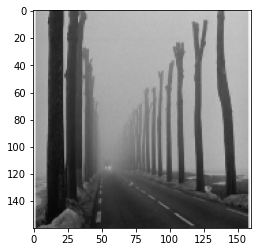

In [37]:
# create a GUI class object
g = GUI()

In [14]:
"여행" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', "여행으로"))

True

In [15]:
"추천" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', "추천수로좀~"))

True

In [16]:
"회수" in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', "주회수로볼게"))

True

In [17]:
"회수 " in t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', "조회수"))

False

In [18]:
"날씨".find(' '.join(t.nouns(re.sub(r'[^ ㄱ-ㅣ가-힣]+', '', "날씨사진으로 추천해줘~"))))

-1